In [1]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
#BERT要用的=========================================================================
import tensorflow as tf
from transformers import AutoTokenizer,TFBertModel
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense
tf.config.run_functions_eagerly(True)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#之後用到kaggle上要加的?
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [50]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
sample=pd.read_csv('./datasets/sample_submission.csv')

# Exploratory Data Analysis (EDA)

In [4]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('Trining dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('Test dataset has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

Trining dataset has 7613 rows and 5 columns
Test dataset has 3263 rows and 4 columns


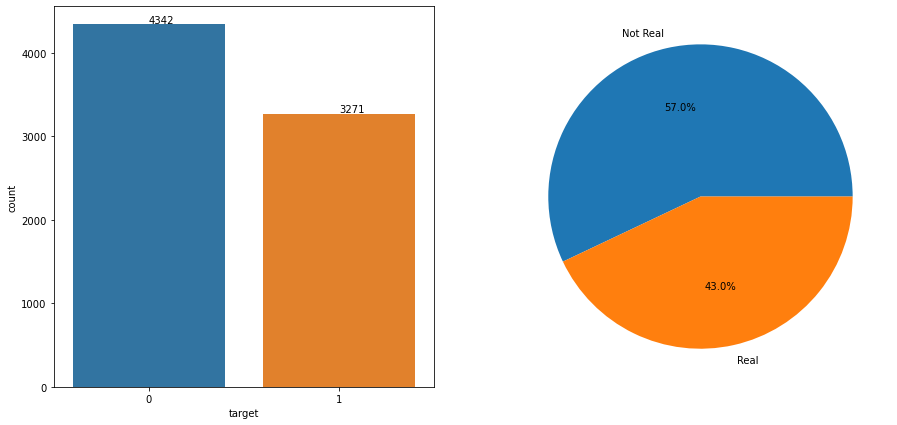

In [7]:
def barh(ax):
    
    for p in ax.patches:
        val = p.get_height() #height of the bar
        x = p.get_x()+ p.get_width()/2 # x- position 
        y = p.get_y() + p.get_height() + 15 #y-position
        ax.annotate(round(val,2),(x,y))

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
ax = sns.countplot(train['target'])
barh(ax)
labels = ['Not Real','Real']
plt.subplot(1,2,2)
plt.pie(train.groupby(['target']).count()['id'],labels=labels, autopct='%1.1f%%')

plt.show()

In [8]:
train[train["target"] == 1]["text"].values[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [9]:
train[train["target"] == 0]["text"].values[:3]

array(["What's up man?", 'I love fruits', 'Summer is lovely'],
      dtype=object)

In [10]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

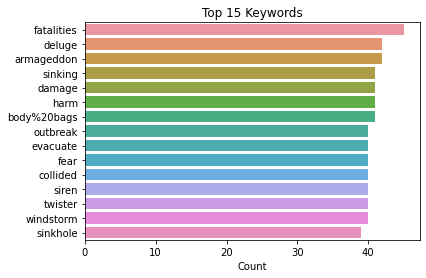

In [11]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:15].index, x=keywords_vc[0:15]["Count"], orient='h')
plt.title("Top 15 Keywords")
plt.show()

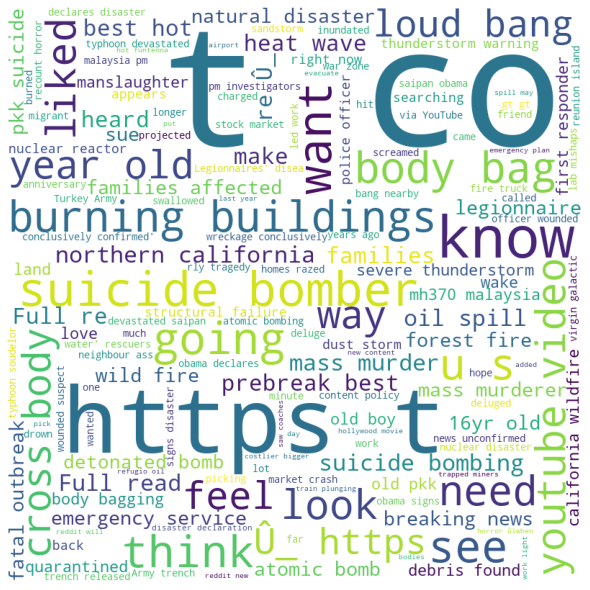

In [12]:
stopwordSet = set(STOPWORDS)
tweet_words = ''
for tweet in train['text']:
    tweet = str(tweet)
    tokens = tweet.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tweet_words += ' '.join(tokens) + ' '
        
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwordSet,
                min_font_size = 10).generate(tweet_words)
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Data Cleaning & Preprocessing (regular expression)

In [13]:
train.drop(['id','location','keyword'],axis=1,inplace=True)

In [14]:
def preprocess_text(text):
    
    text=re.sub('<[^>]*>','',text)
    text=re.sub("[^A-Za-z" "]+"," ",text).lower()
    text=re.sub("[0-9" "]+"," ",text)
    emojis=re.findall('(?::|;|=)(?:-)?(?:)|(|D|P)',text)
    text=re.sub('[\W]+',' ',text.lower()) + ' '.join(emojis).replace('-','')

    text_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    # removing stop words
    filtered_text = []
    for w in text_tokens:
        if w not in stop_words:
            filtered_text.append(w)

    # returning it back to sentence
    return " ".join(filtered_text)

In [15]:
train['text'] = train.text.apply(preprocess_text)

In [16]:
train.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


# 使用RandomForestClassifier、ExtraTreesClassifier

In [37]:
cv = CountVectorizer(max_features = 3000)

In [38]:
X = cv.fit_transform(train['text']).toarray()

Y = train["target"]

In [39]:
Y

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target, Length: 7613, dtype: int64

In [40]:
X_test = cv.transform(test["text"]).toarray()

In [41]:
print(X.shape, X_test.shape)

(7613, 3000) (3263, 3000)


In [44]:
x_train,x_test,y_train,y_test = train_test_split(X,Y, random_state = 21, test_size = 0.2)

In [53]:
models  = {
    "RandomForestClassifier" : make_pipeline(RandomForestClassifier()),
    "ExtraTreesClassifier" : make_pipeline(ExtraTreesClassifier())
}

In [54]:
fit_models = {}
for algo,pipeline in models.items():
    model = pipeline.fit(x_train,y_train)
    fit_models[algo] = model

In [56]:
#訓練數據的分數
for model in fit_models:
    print(f" {model} : {fit_models[model].score(x_train,y_train)*100}%")

 RandomForestClassifier : 98.68637110016421%
 ExtraTreesClassifier : 98.70279146141215%


In [57]:
#測試數據的分數
scores = {}
for model in fit_models:
    print(f" {model} : {fit_models[model].score(x_test,y_test)*100:.2f}%")
    scores[model] = fit_models[model].score(x_test,y_test)

 RandomForestClassifier : 79.25%
 ExtraTreesClassifier : 78.46%


In [51]:
#檢查sample樣本數據
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [59]:
predictions = fit_models["RandomForestClassifier"].predict(X_test)
predictions[:20]

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [60]:
sample["target"] = predictions

In [62]:
sample.target.value_counts()

0    2137
1    1126
Name: target, dtype: int64

In [63]:
sample

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


# BERT and Embedding Model

In [21]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

x_train = tokenizer(
    text=train.text.tolist(),
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

x_test = tokenizer(
    text=test.text.tolist(),
    add_special_tokens=True,
    max_length=50,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [22]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']
y_train = to_categorical(y_train) #分類災難(0 OR 1)

In [23]:
input_ids.shape, attention_mask.shape

(TensorShape([7613, 50]), TensorShape([7613, 50]))

In [24]:
max_len = 50
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
output = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(output)
out = tf.keras.layers.Dropout(0.1)(output)
out = Dense(32,activation = 'relu')(output)
y = Dense(2,activation = 'sigmoid')(output)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [25]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)